<a href="https://colab.research.google.com/github/invest41/CellScan/blob/main/Malaria_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong>CellScan</strong></center></h1>

|||
|:--|:--|
|<img height=300 width=500 src="https://www.thecitizen.co.tz/resource/image/2692740/landscape_ratio16x9/1160/652/b4046770a3577a00b66fd99687e4d0e4/IX/pic-malaria.jpg"/>|<img height=300 width=500 src="https://media.sciencephoto.com/image/f0277662/800wm/F0277662-Protozoan_Plasmodium_falciparum_in_the_stage_of_ring_form_tr.jpg"/>|

### **Introduction**
CellScan - A screening tool leveraging on a brilliant deep learning backed system of algorithms, that would accurately detect malaria parasites from cell images, giving results at an incredible speed! 

The deep learning algorithm studies critically, thousands of images and is able to learn patterns (weights) that exist in these samples via Supervised Learning through Convolutional Neural Networks (CNN), so that it can accurately predict the presence of Malaria parasites in an image, and hence save lives.

We are combining our unique AI technology with Blockchain technology, to aid with a distributed and secure architecture, that promotes authenticity and integration of the Lab datasets processed by our AI technology.

### **Setting the environment**

In [ ]:
import os, time, random
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping



from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
sns.set_theme()

### **Exploratory Data Analysis**

In [ ]:
#Extraction process
!pip install patool -U -q

import patoolib
for file_name in ["/content/drive/MyDrive/CellScan/Parasitized/Parasitized.rar", "/content/drive/MyDrive/CellScan/Uninfected/Uninfected.rar"]: 
  patoolib.extract_archive(file_name, outdir="/content/")

patool: Extracting /content/drive/MyDrive/CellScan/Parasitized/Parasitized.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/CellScan/Parasitized/Parasitized.rar
patool:     with cwd='/content/'
patool: ... /content/drive/MyDrive/CellScan/Parasitized/Parasitized.rar extracted to `/content/'.
patool: Extracting /content/drive/MyDrive/CellScan/Uninfected/Uninfected.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/CellScan/Uninfected/Uninfected.rar
patool:     with cwd='/content/'
patool: ... /content/drive/MyDrive/CellScan/Uninfected/Uninfected.rar extracted to `/content/'.


In [ ]:
#Access Dataset

data, labels, full_data = [], [], []

def arr_agg(tree, collector, id, labels = labels, data = data):
  '''Aggregate all image arrays into a single collector
  '''
  files = os.listdir(tree)
  for img in files:
    try:
        image=cv2.imread(tree + "/" + img)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        
        data.append(np.array(size_image))
        labels.append(id)
        
        full_data.append([np.array(size_image), id]) #most important
    
    except AttributeError as ae:  pass #print(ae)

In [ ]:
tick = time.time()

arr_agg("./Parasitized/", full_data, 1)
arr_agg("./Uninfected/", full_data, 0)


tock = time.time()
print(f'Done!\n{round((tock-tick),2)} seconds...')

Done!
21.15 seconds...


In [ ]:
pd.Series(full_data).shape

(27699,)

In [ ]:
#Map binary class 
from collections import Counter

c = Counter()
for i,j in full_data: c[j] += 1
print(c)

Counter({1: 14394, 0: 13305})


In [ ]:
import numpy as np
from itertools import chain

def _indexing(x, indices):
    """
    :param x: array from which indices has to be fetched
    :param indices: indices to be fetched
    :return: sub-array from given array and indices
    """
    # np array indexing
    if hasattr(x, 'shape'):
        return x[indices]

    # list indexing
    return [x[idx] for idx in indices]



def train_test_split(*arrays, test_size=0.25, shufffle=True, random_seed=1):
    """
    splits array into train and test data.
    :param arrays: arrays to split in train and test
    :param test_size: size of test set in range (0,1)
    :param shufffle: whether to shuffle arrays or not
    :param random_seed: random seed value
    :return: return 2*len(arrays) divided into train ans test
    """
    # checks
    assert 0 < test_size < 1
    assert len(arrays) > 0
    length = len(arrays[0])
    for i in arrays:
        assert len(i) == length

    n_test = int(np.ceil(length*test_size))
    n_train = length - n_test

    if shufffle:
        perm = np.random.RandomState(random_seed).permutation(length)
        test_indices = perm[:n_test]
        train_indices = perm[n_test:]
    else:
        train_indices = np.arange(n_train)
        test_indices = np.arange(n_train, length)

    return list(chain.from_iterable((_indexing(x, train_indices), _indexing(x, test_indices)) for x in arrays))

In [ ]:
#Data split
train_set, val_set = train_test_split(full_data, test_size = 0.20)

In [ ]:
pd.Series(train_set).dtype, pd.Series(train_set).shape

(dtype('O'), (22159,))

In [ ]:
from collections import Counter
c=Counter()
for i,j in val_set:
   c[j] += 1
print(c)

Counter({1: 2955, 0: 2585})


In [ ]:
X_train = []
y_train = []
X_val = []
y_val = []
for tr in train_set:
    X_trainn, y_trainn = tr
    X_train.append(X_trainn)
    y_train.append(y_trainn)

for te in val_set:
    X_vall, y_vall = te
    X_val.append(X_vall)
    y_val.append(y_vall)

In [ ]:
print("X_train =",len(X_train), " , ",
      "X_test =", len(X_val), " , ",
      "y_train =", len(y_train), " , ",
      "y_test =", len(y_val))

X_train = 22159  ,  X_test = 5540  ,  y_train = 22159  ,  y_test = 5540


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout() 
    plt.show()

In [ ]:
#Randomly display images
def plotImages(X):
    '''Selects and displays images from our dataset at random
    '''

    #Selecting the random index
    rand = random.choice(tf.range(0,len(X)))
    rand2 = random.randint(0,len(X))
    rand3 = random.randint(0,len(X))
    
    #Image Display
    fig, ax = plt.subplots(1, 3, figsize=(16, 30))
    
    ax[0].imshow(X[rand])
    ax[0].set_title(f"Sample of cell histology - {X[rand].argmax()} ", weight = "bold", fontsize = 15)
    ax[1].imshow(X[rand2])
    ax[1].set_title(f"Sample of cell histology - {X[rand2].argmax()}", weight = "bold", fontsize = 15)
    ax[2].imshow(X[rand3])
    ax[2].set_title(f"Sample of cell histology - {X[rand3].argmax()}", weight = "bold", fontsize = 15)

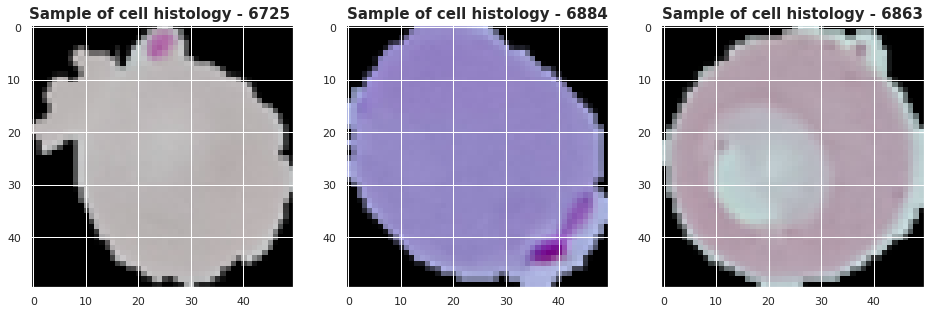

In [ ]:
#Selects random images of cell histology and plots them
random.seed(25)
plotImages(X_train)

In [ ]:
#Normalize
pixel = 255.0 # Max Value

X_train = np.array(X_train, dtype=np.float32)/pixel
X_val = np.array(X_val, dtype=np.float32)/pixel

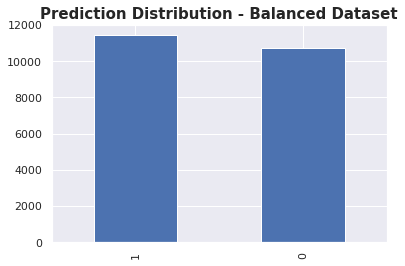

In [ ]:
plt.title('Prediction Distribution - Balanced Dataset', weight = "bold", fontsize = 15)
pd.Series(y_train).value_counts().plot.bar()

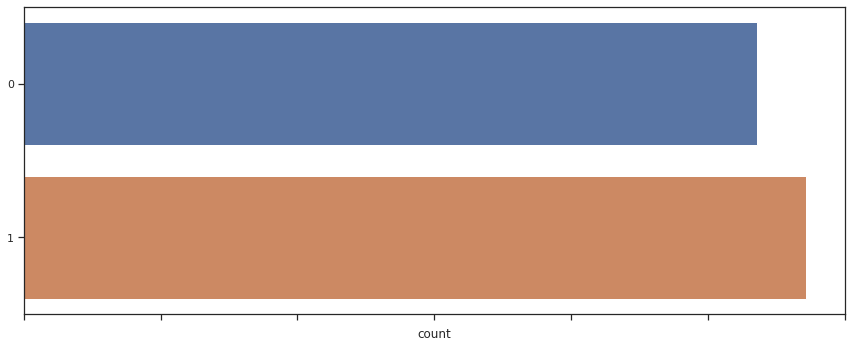

In [ ]:
plt.figure(figsize=(12,5))
sns.set(rc={'figure.figsize':(50, 15)}, style='ticks')
g = sns.countplot(y=y_train)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
#Doing One hot encoding as classifier has multiple classes
num_classes=len(np.unique(y_train))
y_train=keras.utils.to_categorical(y_train,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_train.shape

(22159, 50, 50, 3)

In [ ]:
y_train.shape

(22159, 2)

### **Model Building**

In [ ]:
#Set Seed
tf.random.set_seed(42)

#Set callback - validation loss tracking
callback = EarlyStopping(monitor='val_loss', patience=5)




#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax")) #2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [ ]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Fit the model with min batch size as 50 [can tune batch size to some factor of 2^power ] 
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[callback], batch_size=32, epochs=50, verbose=1)

Epoch 1/50
693/693 [==============================] - 16s 7ms/step - loss: 0.3566 - accuracy: 0.8322 - val_loss: 0.1660 - val_accuracy: 0.9437
Epoch 2/50
693/693 [==============================] - 6s 9ms/step - loss: 0.1429 - accuracy: 0.9537 - val_loss: 0.1285 - val_accuracy: 0.9583
Epoch 3/50
693/693 [==============================] - 4s 6ms/step - loss: 0.1221 - accuracy: 0.9592 - val_loss: 0.1320 - val_accuracy: 0.9587
Epoch 4/50
693/693 [==============================] - 4s 5ms/step - loss: 0.1106 - accuracy: 0.9615 - val_loss: 0.1134 - val_accuracy: 0.9603
Epoch 5/50
693/693 [==============================] - 4s 5ms/step - loss: 0.1038 - accuracy: 0.9627 - val_loss: 0.1135 - val_accuracy: 0.9605
Epoch 6/50
693/693 [==============================] - 4s 5ms/step - loss: 0.1000 - accuracy: 0.9639 - val_loss: 0.1090 - val_accuracy: 0.9601
Epoch 7/50
693/693 [==============================] - 4s 5ms/step - loss: 0.0977 - accuracy: 0.9655 - val_loss: 0.1134 - val_accuracy: 0.9599
Epoch

### **Model Evaluation**

In [ ]:
accuracy = model.evaluate(X_val, y_val, verbose=1)
print('\n', 'Val_Accuracy:-', accuracy)

174/174 [==============================] - 1s 3ms/step - loss: 0.1156 - accuracy: 0.9583

 Val_Accuracy:- [0.1155613511800766, 0.9583032727241516]


In [ ]:
# predict crisp classes for test set
yhat_classes = model.predict(X_val, verbose=0)

In [ ]:
yhat_classes = np.argmax(yhat_classes, axis=1)
yhat_classes

array([1, 0, 1, ..., 1, 0, 0])

In [ ]:
y_val = np.argmax(y_val, axis=1)
y_val

array([1, 0, 1, ..., 1, 0, 0])

In [ ]:

# Accuracy
accuracy = accuracy_score(y_val, yhat_classes)
print('Accuracy: %f' % accuracy, end = ", ")

# Precision tp / (tp + fp)
precision = precision_score(y_val, yhat_classes, average = "weighted")
print('Precision: %f' % precision, end = ", ")

# Recall: tp / (tp + fn)
recall = recall_score(y_val, yhat_classes, average = "weighted")
print('Recall: %f' % recall, end = ", ")

# F1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, yhat_classes, average = "weighted")
print('F1 score: %f' % f1)

Accuracy: 0.958303, Precision: 0.958402, Recall: 0.958303, F1 score: 0.958318


In [ ]:
print(confusion_matrix(y_val, yhat_classes))

[[2486   99]
 [ 132 2823]]


In [ ]:
print(classification_report(y_val, yhat_classes))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2585
           1       0.97      0.96      0.96      2955

    accuracy                           0.96      5540
   macro avg       0.96      0.96      0.96      5540
weighted avg       0.96      0.96      0.96      5540



In [ ]:
#from keras.models import load_model
model.save('/content/drive/MyDrive/CellScan/Malaria_cell_classifation.h5')

In [ ]:
#from tensorflow.keras.models import load_model
#model1 = tf.keras.models.load_model("/content/drive/MyDrive/CellScan/Malaria_cell_classifation.h5")

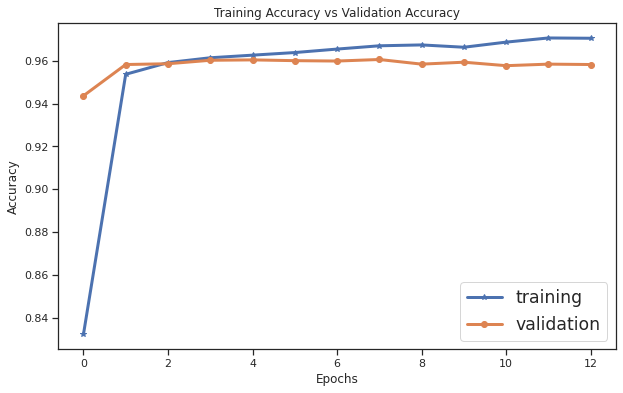

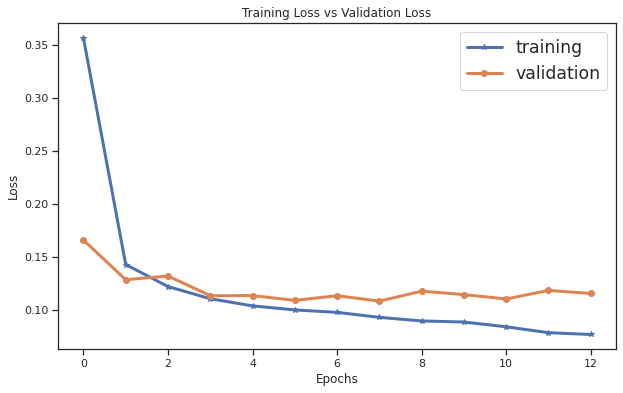

In [47]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

### **Thanks for Viewing**